In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import stats
from scipy.stats import norm
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

## Disclaimer
This notebook based on my final project for Inferential Statistics course by Duke University from https://www.coursera.org/learn/inferential-statistics-intro <br>

## Part 1: Data
For this project I worked with collected by the National Opinion Research Center (NORC) dataset, which have been produced using questionnaires from 1972 to 2012. Dataset includes 57,061 observations (one for each respondent) and 114 variables (one for each question asked). NORC’s description is stated below:<br>
<blockquote>Since 1972, the General Social Survey (GSS) has been monitoring societal change and studying the growing complexity of American society. The GSS aims to gather data on contemporary American society in order to monitor and explain trends and constants in attitudes, behaviors, and attributes; to examine the structure and functioning of society in general as well as the role played by relevant subgroups; to compare the United States to other societies in order to place American society in comparative perspective and develop cross-national models of human society; and to make high-quality data easily accessible to scholars, students, policy makers, and others, with minimal cost and waiting.</blockquote> <br>
Source: <a href="https://www.norc.org/Research/Projects/Pages/general-social-survey.aspx" title="Wikipedia">Abstract for the General Social Survey</a>

## Part 2: Research question
### Background and question:

Sam Harris, American author, philosopher and neuroscientist, in his Letter to a Christian Nation stated:<br>
<blockquote>While political party affiliation in the United States is not a perfect indicator of religiosity, it is no secret that the ‘red [Republican] states’ are primarily red due to the overwhelming political influence of conservative Christians.</blockquote> <br>
I decided to check if there are any differences between proportions of religious and non-religious persons among people with liberal political views. As the survey was made by random sampling, the results of this work can be projected on the whole U.S. population.

### Extract of necessary data

For project purposes I took three variables:

1. **relig** - categorical variable, which shows religous preferences of respondets<br>
2. **polviews** - categorical variable, which shows respondents on a a seven-point scale from extremely liberal - point 1 - to extremely conservative - point 7<br>
3. **year** - variable used for understanding trends in observable periods

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/AntonIsHere/Inferetial_Statistics/master/gss.csv")
pd.set_option('mode.chained_assignment', None)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
n = df['relig'].count() 
df

,relig,polviews,year,At_NonAt,Wing
0,Protestant,Moderate,1974,Religious,Other
1,Protestant,Slightly Conservative,1974,Religious,Other
2,Protestant,Conservative,1974,Religious,Other
3,Protestant,Conservative,1974,Religious,Other
4,Protestant,Conservative,1974,Religious,Other
...,...,...,...,...,...
47723,None,Liberal,2012,Non_religious,Liberal
47724,Catholic,Moderate,2012,Religious,Other
47725,Catholic,Moderate,2012,Religious,Other
47726,Catholic,Slightly Conservative,2012,Religious,Other


### Assumptions made:
**Assumption 1:** For the separation of respondents into two groups “Religious” and “Non-religious” I made an assumption, that every respondents who answered “None” about his religious preferences is Non-religious person. Other respondents are assumed to be religious persons.<br>
**Assumption 2:** Respondents who answered “Liberal”, “Slightly Liberal” or “Extremely Liberal” about their political views were combined into one group “Liberal”

## Part 3: Exploratory data analysis
For proportional analysis I calculated % of religious and non-religious liberals. Before analysis, I had an opinion that liberals represent the majority of non-religious people if we divide people on political views.

#### SQL parameters:
**Rel_L** - number of respondents with **'Religious'** and **'Liberal'** characteristics<br>
**Non_Rel_L** - number of respondents with **'Non_Religious'** and **'Liberal'** characteristics<br>
**Rel_O** - number of respondents with **'Religious'** and **'Other'** characteristics<br>
**Non_Rel_O** - number of respondents with **'Non_Religious'** and **'Other'** characteristics

In [3]:
q = """Select year, (Rel_L*100.00/(Rel_O+Rel_L)) prop_Rel_L,(Non_Rel_L*100.00/(Non_Rel_O+Non_Rel_L)) prop_Non_Rel_L, Rel_L, Non_Rel_L, Rel_O, Non_Rel_O FROM
(Select * from (Select year, count(At_NonAt) as Rel_L from df where At_NonAt = 'Religious' and Wing = 'Liberal' Group by year) a 
left join 
(Select year, count(At_NonAt) as Non_Rel_L from df where At_NonAt = 'Non_religious' and Wing = 'Liberal' Group by year) b
ON a.year = b.year
left join 
(Select year, count(At_NonAt) as Non_Rel_O from df where At_NonAt = 'Non_religious' and Wing = 'Other' Group by year) c
ON a.year = c.year
left join
(Select year, count(At_NonAt) as Rel_O from df where At_NonAt = 'Religious' and Wing = 'Other' Group by year) d
ON a.year = d.year)"""

gss_distr = pysqldf(q)
gss_distr.head()

,year,prop_Rel_L,prop_Non_Rel_L,Rel_L,Non_Rel_L,Rel_O,Non_Rel_O
0,1974,28.419453,59.574468,374,56,942,38
1,1975,27.916019,56.880734,359,62,927,47
2,1976,26.955848,51.851852,348,56,943,52
3,1977,27.525622,51.219512,376,42,990,40
4,1978,26.631259,46.491228,351,53,967,61


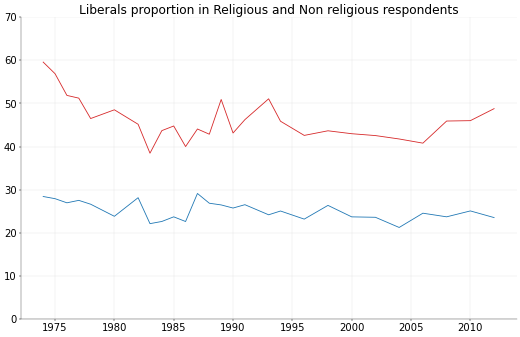

In [4]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 40)
plt.plot('year', 'prop_Non_Rel_L', data=gss_distr, color='tab:red')
plt.plot('year', 'prop_Rel_L', data=gss_distr, color='tab:blue')

# Decoration
plt.ylim(0, 70)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title("Liberals proportion in Religious and Non religious respondents", fontsize=22)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.7)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.7)   
plt.show()

The graph above changed my opinion. According to these samples, liberals represent almost 50% of non-religious people and they are not the majority. But we can see that the proportion for non-religious is above than from religious among liberals.

## Part 4: Inference
### Hypothesis
**Null hypothesis (H0):** The mean difference in proportions of liberal non-religious and religious persons is zero.<br>
**Alternate hypothesis (HA):** The mean difference in proportions of liberal non-religious and religious persons is greater than zero.<br>
For hypothesis testing I will use one-sided z-test for two independent sample proportions because there is a large sample with unknown variance and the differences can be met only to the left from 0 on the graph.

### Conditions check in context of the data
There should be 2 checks: for independence and sample/size skew

**1. Independence:**

<ul>
 <li>within groups: Random sample conducted and n is less than 10%</li>
 <li>between groups: Observable groups are independent from each other</li>
 </ul>

**2. Sample size/skew** <br> 
For this condition the number of successes and failures was calculated using the code below:

In [5]:
q = """SELECT SUM(Rel_L) Rel_L, SUM(Non_Rel_L) Non_Rel_L, SUM(Rel_O) Rel_O, SUM(Non_Rel_O) Non_Rel_O FROM gss_distr"""
gss_distr_aggr = pysqldf(q)
p_pool = (gss_distr_aggr.iloc[0]['Rel_L']+gss_distr_aggr.iloc[0]['Non_Rel_L'])/n
n_1 = (gss_distr_aggr.iloc[0]['Rel_L']+gss_distr_aggr.iloc[0]['Rel_O'])
n_2 = (gss_distr_aggr.iloc[0]['Non_Rel_L']+gss_distr_aggr.iloc[0]['Non_Rel_O'])
n_1_success = p_pool * n_1
n_1_fails = (1 - p_pool) * n_1
n_2_success = p_pool * n_2
n_2_fails = (1 - p_pool) * n_2
SE = ((p_pool*(1 - p_pool)/n_1) + (p_pool*(1 - p_pool)/n_2))**0.5

print('p_pool: ' + str(p_pool))
print('n_1_success: ' + str(n_1_success))
print('n_1_fails: ' + str(n_1_fails))
print('n_2_success: ' + str(n_2_success))
print('n_2_fails: ' + str(n_2_fails))
print('SE: ' + str(SE))

p_pool: 0.27346630908481395
n_1_success: 11623.685467650017
n_1_fails: 30881.31453234998
n_2_success: 1428.3145323499832
n_2_fails: 3794.6854676500166
SE: 0.006535613911283399


Calculations above confirm that the success-failure criterion is met, since there are more than 10 successes and failures. So in this case, theoretical approach can be used instead of simulations.

### Distribution and p-value
Since all the conditions are met, **p-value** can be calculated using this code:

In [6]:
p_hat_Religious = gss_distr_aggr.iloc[0]['Rel_L']/(gss_distr_aggr.iloc[0]['Rel_L']+gss_distr_aggr.iloc[0]['Rel_O'])
p_hat_Non_Religious = gss_distr_aggr.iloc[0]['Non_Rel_L']/(gss_distr_aggr.iloc[0]['Non_Rel_L']+gss_distr_aggr.iloc[0]['Non_Rel_O'])
point_estimate = p_hat_Non_Religious - p_hat_Religious
Z = (point_estimate-0)/SE

Test statistic shows us that differences in proportions are **30.5489** standard deviations away from the mean, so it gives us almost zero p-value and we can reject the null hypothesis.

In [7]:
CI = point_estimate + np.array([-1, 1]) * norm.ppf(0.995) *((((p_hat_Non_Religious * (1-p_hat_Non_Religious))/n_2)+((p_hat_Religious * (1-p_hat_Religious))/n_1))**0.5)

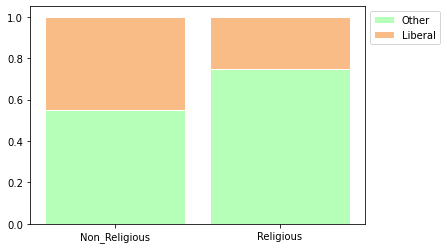

Confidence interval: 18.11% - 21.82%


In [8]:
# Data
r = [0,1]
raw_data = {'greenBars': [p_hat_Religious, 1-p_hat_Religious], 'orangeBars': [p_hat_Non_Religious, 1-p_hat_Non_Religious]}
df_bar = pd.DataFrame(raw_data)
 
# From raw value to percentage
#totals = [i+j+k for i,j,k in zip(df['greenBars'], df['orangeBars']]
greenBars = [1-p_hat_Non_Religious, 1-p_hat_Religious]
orangeBars = [p_hat_Non_Religious, p_hat_Religious]
 
# plot
barWidth = 0.85
names = ('Non_Religious','Religious')
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label = "Other")
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth, label = "Liberal")
 
# Custom x axis
plt.xticks(r, names)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
 
# Show graphic
plt.show()
print('Confidence interval: ' +str(round(CI[0]*100,2)) + '% - ' + str(round(CI[1]*100,2)) + '%')

We are 99% confident that the proportion of non-religious respondents, who has liberal political views, is **18.11% to 21.82%** higher than the proportion of religious with liberal political views.

## Conclusion
As concluded in Part 3: Exploratory data analysis, I expected to see that the proportion for non-religious is above than from religious among liberals. Conducting statistical test of two independent I gained strong evidence of the higher proportion of liberals than in non-religious respondents. This project does not provide causality relationships between political and religious views, but further investigations about attributes of liberal and conservative people can be conducted.